<font size="5"> **Stable Diffusion Inference for Text2Image on Intel GPU** </font> 
<br>
This code sample will perform stable diffusion inference based on the text prompt using KerasCV implementation while using Intel® Extension for Tensorflow*. We optimized official keras-cv Stable Diffusion, eg, concatenate two forward pass, combine computation in loops to reduce op number, add fp16 mode for model. The following run cases are executed:<br>
* FP32 (baseline) <br>
* Enable FP16 precision for faster inference <br>

<font size="5">**Environment Setup**</font>  <br>
Ensure the env_itex kernel is activated before running this notebook.

In [1]:
import time
from keras_cv.models.stable_diffusion import StableDiffusion
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

2023-07-26 22:58:36.965680: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-26 22:58:36.967320: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 22:58:36.997050: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 22:58:36.997549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 22:58:39.655408: W tensorflow/compiler/tf2t

<font size ="5">**Helper Functions**</font>

The functions below will help us plot the images.

In [2]:
def plot_images(images):
    png_name = "{}_{}imgs_{}steps.png".format(
        precision, batch_size, num_steps)
    
    print("Start plotting the generated images to %s" % (png_name))
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

<font size ="5">**Model Loading**</font> <br>
First, we construct a model and also define few of the required parameters:</font>

In [3]:
iterations = 2
use_xla = False
precision = 'fp32'
batch_size = 1
num_steps = 50
seed= 12345
benchmark_result = []

model = StableDiffusion(
    img_width=512,
    img_height=512,
    jit_compile=use_xla,
    precision=precision,
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


<font size ="5">**Running Inference** </font> <br>
Next, we give it a prompt:

Start Warmup


2023-07-26 22:58:49.342249: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform XPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-26 22:58:49.342275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform XPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-26 22:58:49.342279: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform XPU ID 2, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-26 22:58:49.342283: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform XPU ID 3, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-26 22:58:49.342318: I tensorflow/core/common_runtime/plu

text_encoder before:  [dtype('float32')]


2023-07-26 22:59:06.992300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type XPU is enabled.


50/50 [==============================] - 33s 232ms/step


2023-07-26 22:59:28.158431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type XPU is enabled.


Start running inference and generating images
50/50 [==============================] - 12s 236ms/step
FP32 precision: 12.16 seconds
Start plotting the generated images to fp32_1imgs_50steps.png


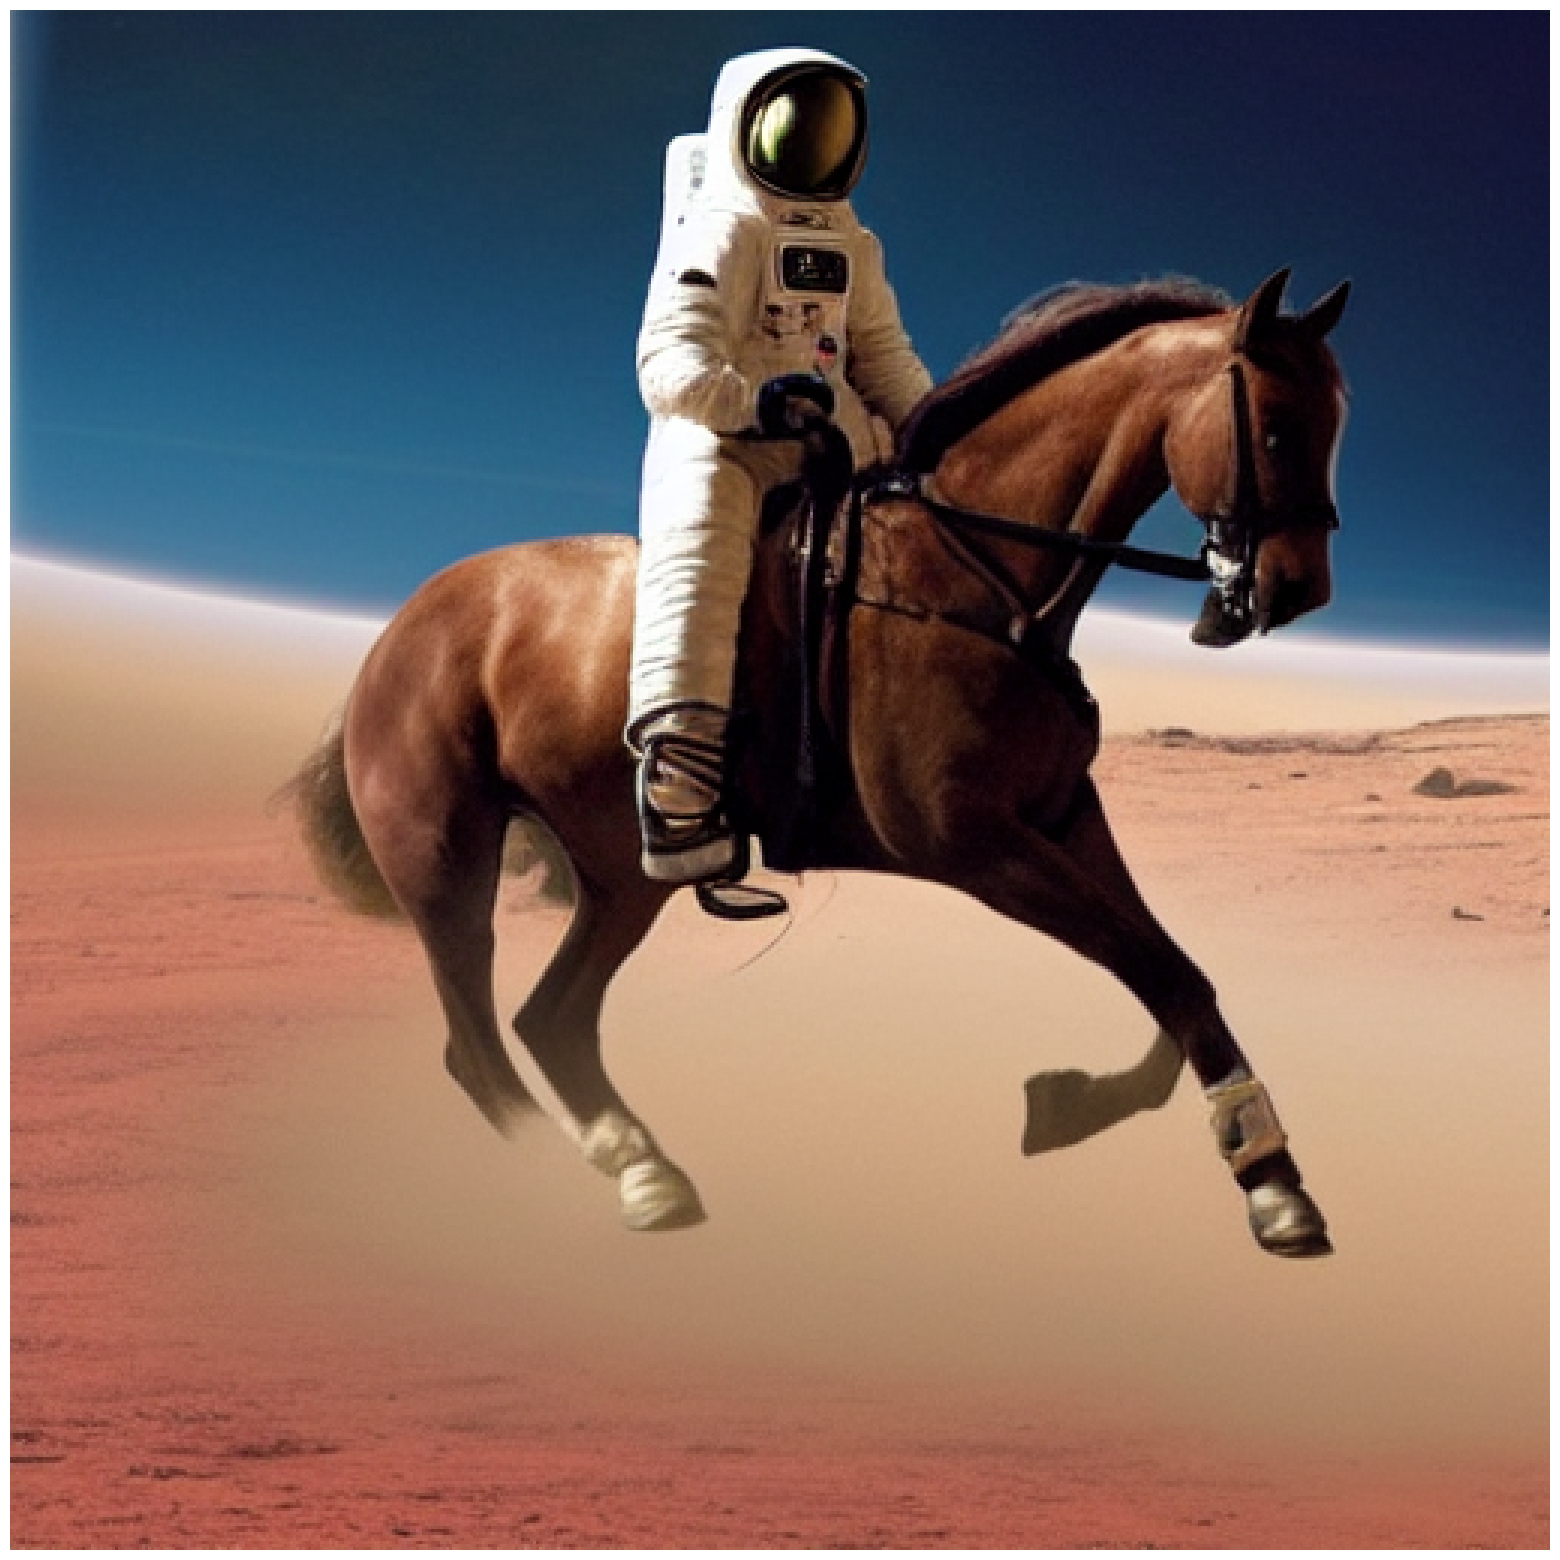

In [4]:
prompt = "a photo of an astronaut riding a horse on mars"

print("Start Warmup")
model.text_to_image(
    "warming up the model", batch_size=batch_size, num_steps=num_steps
)
# Start inference
print("Start running inference and generating images")
t = 0
for i in range(iterations):
    start_time = time.time()
    images = model.text_to_image(prompt=prompt, batch_size=batch_size, seed=seed)
    t+=(time.time() - start_time)
print(f"FP32 precision: {(t/iterations):.2f} seconds")
benchmark_result.append(["FP32 precision", t/iterations])
plot_images(images)

<font size="4">**Performance computation using float16 precision** </font>
<br>
We optimized official keras-cv Stable Diffusion to add fp16 mode for model.</font>

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
Start Warmup
text_encoder before:  [dtype('float32')]
text_encoder after:  [dtype('float16')]


2023-07-26 22:59:58.735889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type XPU is enabled.


text_encoder before:  [dtype('float16')]


2023-07-26 23:00:13.733164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type XPU is enabled.


50/50 [==============================] - 29s 135ms/step


2023-07-26 23:00:31.281728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type XPU is enabled.


Start running inference and generating images
50/50 [==============================] - 7s 130ms/step
FP16 precision: 6.80 seconds
Start plotting the generated images to fp16_1imgs_50steps.png


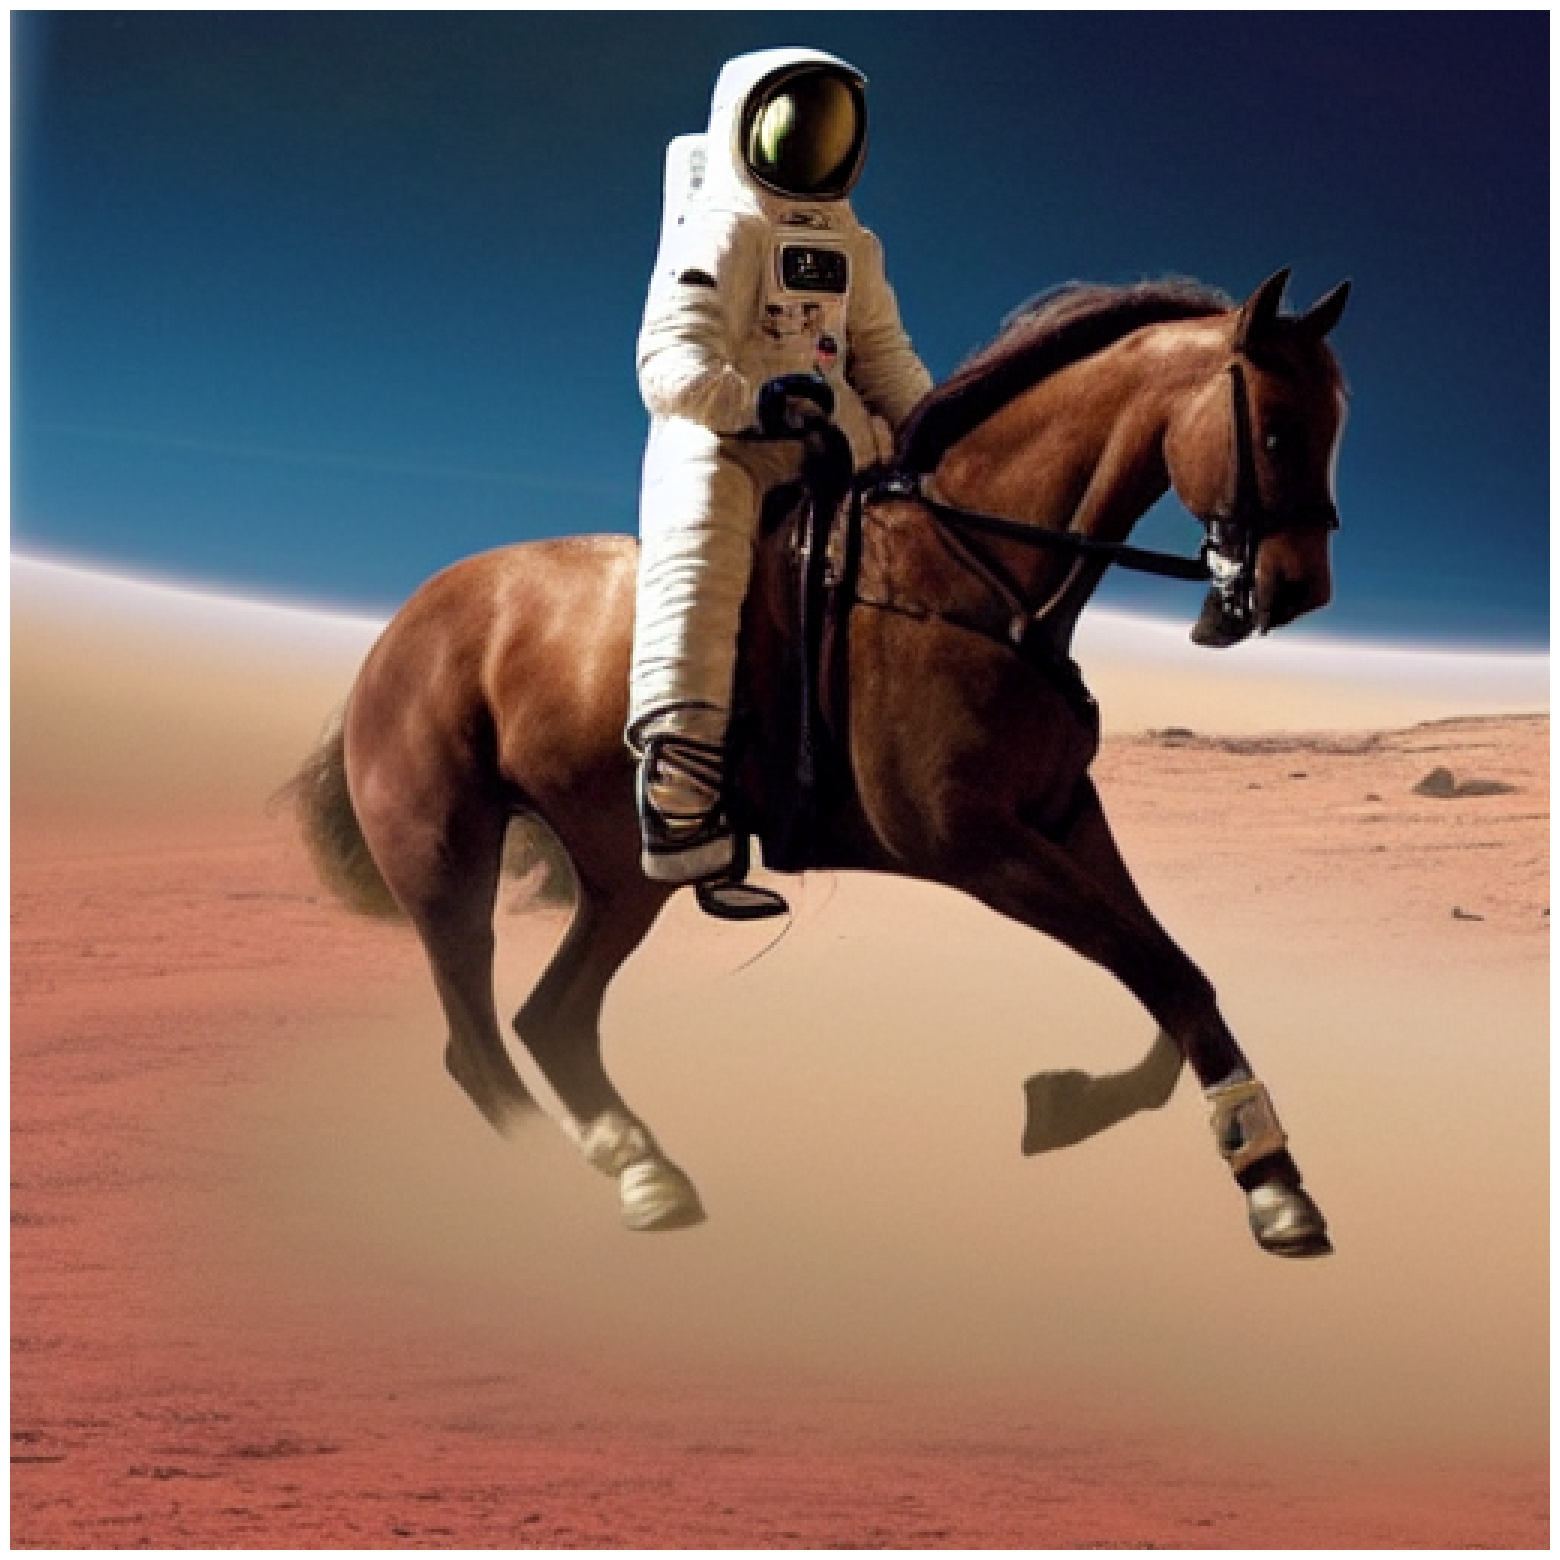

In [5]:
precision = 'fp16'

model = StableDiffusion(
    img_width=512,
    img_height=512,
    jit_compile=use_xla,
    precision=precision,
)

print("Start Warmup")
model.text_to_image(
    "warming up the model", batch_size=batch_size, num_steps=num_steps
)
# Start inference
print("Start running inference and generating images")
t = 0
for i in range(iterations):
    start_time = time.time()
    images = model.text_to_image(prompt=prompt, batch_size=batch_size, seed=seed)
    t+=(time.time() - start_time)
    
print(f"FP16 precision: {(t/iterations):.2f} seconds")
benchmark_result.append(["FP16 precision", t/iterations])
plot_images(images)

<font size ="5">**Performance comparison** <br></font>
Lets compare the results wrt inference latency time.

In [6]:
print("{:<20} {:<20}".format("Model", "Runtime"))
for result in benchmark_result:
    name, runtime = result
    print("{:<20} {:<20}".format(name, runtime))

Model                Runtime             
FP32 precision       12.157527208328247  
FP16 precision       6.804440259933472   


<BarContainer object of 2 artists>

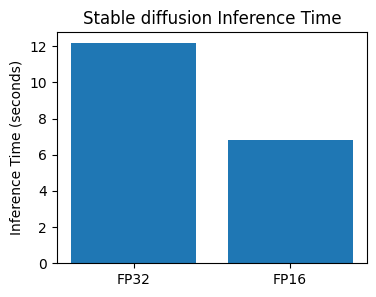

In [7]:
import matplotlib.pyplot as plt

# Create bar chart with training time results
plt.figure(figsize=(4,3))
plt.title("Stable diffusion Inference Time")
plt.ylabel("Inference Time (seconds)")
plt.bar(["FP32", "FP16"], [benchmark_result[0][1], benchmark_result[1][1]])

In [8]:
print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
